### Импорт необходимых библиотек

In [1]:
import os
import re
import cv2
import smtplib
import itertools
import pdfplumber
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from email.mime.text import MIMEText
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from email.mime.multipart import MIMEMultipart
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Сбор и обработка данных

In [38]:
# Основные директории для хранения фотографий автомобилей и номерных знаков
BASE_DIR = './traffic_fines/'
CAR_DIR = os.path.join(BASE_DIR, 'car_photos')
PLATE_DIR = os.path.join(BASE_DIR, 'licence_plate_photos')

In [39]:
# Создаем директории, если они ещё не существуют
def make_dirs():
    os.makedirs(CAR_DIR, exist_ok=True)
    os.makedirs(PLATE_DIR, exist_ok=True)

In [40]:
# Получаем список папок, созданных сегодня
def get_today_folders(path):
    make_dirs()
    today = datetime.today().date()
    folders = [
        os.path.join(path, f)
        for f in os.listdir(path)
        if os.path.isdir(os.path.join(path, f)) and 
            datetime.fromtimestamp(os.path.getctime(os.path.join(path, f))).date() == today
    ]
    return folders

In [41]:
# Извлекаем текст и изображения из PDF-файла
def pdf_extract(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ''
            images = []
            for page in pdf.pages:
                text += page.extract_text() or ''
                for img in page.images:
                    x0, top, x1, bottom = img['x0'], img['top'], img['x1'], img['bottom']
                    image = page.within_bbox((x0, top, x1, bottom)).to_image()
                    images.append(image.original)

            info = {
                'file_name': os.path.splitext(os.path.basename(pdf_path))[0],
                'post_number': re.search(r'ПОСТАНОВЛЕНИЕ\s+(\d+)', text).group(1),
                'violation_date': re.search(r'\d{2}\.\d{2}\.\d{4}(?=\sв\s\d{2}:\d{2}:\d{2})', text).group(0),
                'violation_time': re.search(r'\d{2}.\d{2}.\d{4}\s+в\s+\d{2}:\d{2}:\d{2}', text).group(0).split('в ')[1],
                'location': re.search(r'по адресу\s+([^,]+,\s*\d+\s*км\.,\s*[^.]+)', text).group(1),
                'car_number': re.search(r'государственный регистрационный знак\s+(\w+)', text).group(1),
                'fine_amount': re.search(r'в размере\s+(\d+)\s+руб.', text).group(1),
                'sts_number': re.search(r'СТС:\s+(\d+)', text).group(1)
            }

            for i, img in enumerate(images):
                if i == 0:
                    img.save(os.path.join(CAR_DIR, f"{info['car_number']}_{info['sts_number']}.jpg"))
                else:
                    img.save(os.path.join(PLATE_DIR, f"{info['car_number']}_{info['sts_number']}_plate.jpg"))

            return info

    except Exception as e:
        print(f"Error: {e}")
        return None

In [42]:
# Обрабатываем все папки и извлекаем данные из PDF-файлов
def process_folders(folders):
    data = []
    for folder in folders:
        for file in os.listdir(folder):
            if file.endswith('.pdf'):
                pdf_path = os.path.join(folder, file)
                info = pdf_extract(pdf_path)
                if info:
                    data.append(info)
    return pd.DataFrame(data)

In [128]:
today_folders = get_today_folders(BASE_DIR)
df = process_folders(today_folders)
df

,file_name,post_number,violation_date,violation_time,location,car_number,fine_amount,sts_number
0,12345678909876,12345678999987654321,23.09.2024,15:25:31,"Автодорога Р-260, 335 км., Ростовская обл",А666AА161,500,1234567890


In [130]:
# Новые названия столбцов (в соответствии с заданием)
new_columns = [
    'Номер файла',
    'Постановление',
    'Дата',
    'Время',
    'Адрес',
    'Гос номер',
    'Сумма штрафа',
    'Номер СТС'
]

df.columns = new_columns
df

,Номер файла,Постановление,Дата,Время,Адрес,Гос номер,Сумма штрафа,Номер СТС
0,12345678909876,12345678999987654321,23.09.2024,15:25:31,"Автодорога Р-260, 335 км., Ростовская обл",А666AА161,500,1234567890


In [131]:
df['Сумма штрафа'] = pd.to_numeric(df['Сумма штрафа'])  # Преобразуем в числовой тип

In [132]:
# Добавление столбца "Сумма штрафа > 5000" с условием
df['Сумма штрафа > 5000'] = df['Сумма штрафа'] > 5000
df

,Номер файла,Постановление,Дата,Время,Адрес,Гос номер,Сумма штрафа,Номер СТС,Сумма штрафа > 5000
0,12345678909876,12345678999987654321,23.09.2024,15:25:31,"Автодорога Р-260, 335 км., Ростовская обл",А666AА161,500,1234567890,False


In [133]:
# Перестановка столбцов так, чтобы столбец "Сумма штрафа > 5000" был между "Сумма штрафа" и "Номер СТС"
cols = df.columns.tolist()
cols.insert(cols.index('Номер СТС'), cols.pop(cols.index('Сумма штрафа > 5000')))
df = df[cols]
df

,Номер файла,Постановление,Дата,Время,Адрес,Гос номер,Сумма штрафа,Сумма штрафа > 5000,Номер СТС
0,12345678909876,12345678999987654321,23.09.2024,15:25:31,"Автодорога Р-260, 335 км., Ростовская обл",А666AА161,500,False,1234567890


Перед добавлением и заполнением столбца, в котором осуществляется сравнение гос номера из текста постановления с распознанным при помощи компьютерного зрения, произведём поиск и замену (в случае наличия) кириллических символов в номере из постановления на соответствующие символы латиницы:

In [149]:
def transliterate_char(c):
    # Словарь для преобразования символов
    translit_map = {
        'А': 'A',
        'В': 'B',
        'С': 'C',
        'Е': 'E',
        'Н': 'H',
        'К': 'K',
        'М': 'M',
        'О': 'O',
        'Р': 'P',
        'Т': 'T',
        'Х': 'X',
        'У': 'Y'
    }
    
    return translit_map.get(c, c)

In [136]:
# Применяем функцию к столбцу "Гос номер"
df['Гос номер'] = df['Гос номер'].apply(lambda x: ''.join(transliterate_char(c) for c in x))

In [144]:
# Список для хранения распознанных номеров из PDF-документов
# В данном случае, использовался только один файл - постановление из примера
predicted_numbers = []

# Обработка всех изображений в папке
for filename in os.listdir(PLATE_DIR):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        _, predicted_number = process_image(image_path)
        predicted_numbers.append(predicted_number)

predicted_numbers

['A666AA161']

In [148]:
# Добавление столбца "Фото гос номера соответствует" с условием
df['Фото гос номера соответствует'] = df['Гос номер'] == predicted_numbers
df

,Номер файла,Постановление,Дата,Время,Адрес,Гос номер,Сумма штрафа,Сумма штрафа > 5000,Номер СТС,Фото гос номера соответствует
0,12345678909876,12345678999987654321,23.09.2024,15:25:31,"Автодорога Р-260, 335 км., Ростовская обл",A666AA161,500,False,1234567890,True


### Формирование и отправка писем

In [68]:
# Настройки для отправки почты
SMTP_SERVER = 'smtp.gmail.com'
SMTP_PORT = 587
SENDER_EMAIL = 'your_email@gmail.com'
SENDER_PASSWORD = 'your_password'

In [97]:
# Функция для создания HTML-таблицы из DataFrame
def create_html_table(dataframe):
    html_content = '<table border="1" cellpadding="5" cellspacing="0" style="border-collapse: collapse;"><tr>'
    for column in dataframe.columns:
        html_content += f'<th>{column}</th>'
    html_content += '</tr>'
    
    for _, row in dataframe.iterrows():
        html_content += '<tr>'
        for value in row:
            html_content += f'<td>{value}</td>'
        html_content += '</tr>'
    
    html_content += '</table>'
    return html_content

In [95]:
# Функция для отправки электронного письма
def send_email(recipient, subject, message_body):
    try:
        message = MIMEMultipart()
        message['From'] = SENDER_EMAIL
        message['To'] = recipient
        message['Subject'] = subject
        message.attach(MIMEText(message_body, 'html'))

        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
            server.starttls()
            server.login(SENDER_EMAIL, SENDER_PASSWORD)
            server.sendmail(SENDER_EMAIL, recipient, message.as_string())
            print(f'Письмо успешно отправлено на: {recipient}')
    except Exception as error:
        print(f'Произошла ошибка при отправке письма: {error}')

In [ ]:
# Основной процесс проверки условий и отправки уведомлений
for _, record in df.iterrows():
    if record['Сумма штрафа > 5000']:
        subject = "Сумма штрафа превышает 5000"
        record_df = pd.DataFrame([record])
        body_content = f'<h3>Информация о штрафе:</h3>{create_html_table(record_df)}'
        send_email('mail_num_one@gmail.com', subject, body_content)

    if not record['Фото гос номера соответствует']:
        subject = "Фото гос номера не соответствует"
        record_df = pd.DataFrame([record])
        body_content = f'<h3>Информация о штрафе:</h3>{create_html_table(record_df)}'
        send_email('mail_num_two@gmail.com', subject, body_content)

### Распознавание номера

#### Подготовка данных

In [8]:
# Параметры изображений
img_width, img_height = 128, 64
char_set=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y']
num_classes = len(char_set)  # Количество возможных символов
max_length = 9  # Максимальная длина номерного знака

In [3]:
# Путь к папке с данными для обучения
data_dir = './car_plate_data/train'

In [4]:
# Генератор данных
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [5]:
# Загрузка данных
def load_data(data_dir):
    images = []
    labels = []
    image_paths = []
    for filename in os.listdir(data_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(data_dir, filename)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            img_array = datagen.standardize(img_array)
            images.append(img_array)
            label = filename.split('.')[0]  # Имя файла без расширения - это метка
            labels.append(label)
            image_paths.append(img_path)
    return np.array(images), labels, image_paths

images, labels, image_paths = load_data(data_dir)

In [6]:
# Преобразование меток в числовые значения
char_to_int = dict((c, i) for i, c in enumerate(char_set))
int_to_char = dict((i, c) for i, c in enumerate(char_set))

def encode_label(label):
    encoded = [char_to_int[char] for char in label]
    # Дополняем до максимальной длины нулями
    return np.pad(encoded, (0, max_length - len(encoded)), 'constant', constant_values=0)

encoded_labels = [encode_label(label) for label in labels]

#### Создание модели

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = [Dense(num_classes, activation='softmax')(x) for _ in range(max_length)]

model = Model(inputs=base_model.input, outputs=outputs)

In [8]:
# Компиляция модели
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Подготовка данных для обучения
X_train = images
y_train = np.array([encode_label(label) for label in labels])

In [10]:
# Разделение данных на обучающую и тестовую выборки (80% / 20%)
split_index = int(len(X_train) * 0.8)
X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]
image_paths_train, image_paths_val = image_paths[:split_index], image_paths[split_index:]

In [11]:
# Преобразуем метки в список массивов для каждого символа
y_train_list = [y_train[:, i] for i in range(max_length)]
y_val_list = [y_val[:, i] for i in range(max_length)]

#### Обучение модели

In [ ]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

model.fit(
    X_train, 
    y_train_list, 
    validation_data=(X_val, y_val_list),
    epochs=150, 
    batch_size=8,  
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
# Сохранение модели в формате TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

#### Предсказание на новых данных

In [25]:
# Загрузка модели TFLite
model_path = 'model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [26]:
# Получение деталей входных и выходных тензоров
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
# Путь к папке с изображениями для распознавания
image_folder = './car_plate_data/test'

In [87]:
# Процесс обработки всех изображений в папке
images = []
predicted_texts = []

for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        image, predicted_text = process_image(image_path)
        images.append(image)
        predicted_texts.append(predicted_text)

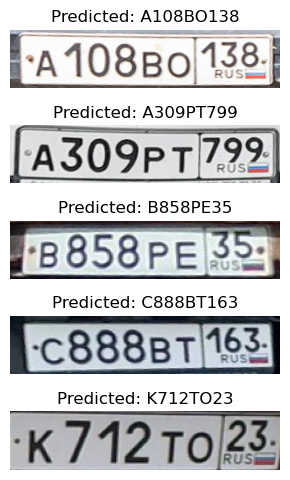

In [28]:
# Визуализация результатов
num_images = len(images)
fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(3, num_images))

if num_images == 1:
    axes.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    axes.set_title(f'Predicted: {predicted_texts[0]}')
    axes.axis('off')
else:
    for ax, image, text in zip(axes, images, predicted_texts):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f'Predicted: {text}')
        ax.axis('off')

plt.tight_layout()
plt.show()